In [1]:
import pickle
import os
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split


%matplotlib inline

### Implement alternative Null Model using basic regression function $\widehat{y} = \alpha + \beta X$

### When expressed in terms of the log for VIX futures prices this becomes: $\widehat{ln(\frac{V_{t}}{V_{t-1}})} = \alpha + \beta ln(\frac{V_{t-1}}{V_{t-2}})$ 

In [223]:
#vx1_opt = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vx1_opt.pkl', "rb"))
master = pd.read_pickle(os.getcwd() + r'\Data\Intraday\Pickle\master.pkl')

In [224]:
master.head()

,SPX_k1,SPX_k2,SPX_ImpVol1,SPX_ImpVol2,DaysTo_VX1_Expiry,DaysTo_VX2_Expiry,VX1_Future,OPT,VX1-OPT_Spread,VIX_ImpVol,SPX_Index(fwd)
2015-01-02 09:40:00,2070.0,2070.0,0.1326,0.1370,11.9931,32.9931,17.175,13.9409,3.2341,1.1445,2071.42
2015-01-02 09:50:00,2070.0,2070.0,0.1325,0.1362,11.9861,32.9861,17.275,13.8315,3.4435,1.1405,2068.27
2015-01-02 10:00:00,2070.0,2065.0,0.1343,0.1386,11.9792,32.9792,17.375,14.0993,3.2757,1.1428,2067.89
2015-01-02 10:10:00,2065.0,2060.0,0.1397,0.1440,11.9722,32.9722,17.725,14.6378,3.0872,1.1837,2062.70
2015-01-02 10:20:00,2065.0,2060.0,0.1407,0.1449,11.9653,32.9653,17.725,14.7280,2.9970,1.1836,2062.38


In [225]:
master[master['VX1_Future'] == 0].head()

,SPX_k1,SPX_k2,SPX_ImpVol1,SPX_ImpVol2,DaysTo_VX1_Expiry,DaysTo_VX2_Expiry,VX1_Future,OPT,VX1-OPT_Spread,VIX_ImpVol,SPX_Index(fwd)


In [226]:
mydata = master['VX1_Future'].to_frame()
mydata['Ratio'] = np.log(mydata['VX1_Future'] / mydata['VX1_Future'].shift(1) )

In [227]:
mydata['shift1'] = mydata['Ratio'].shift(1)
mydata['shift2'] = mydata['Ratio'].shift(2)
mydata['shift3'] = mydata['Ratio'].shift(3)
mydata['shift4'] = mydata['Ratio'].shift(4)
mydata['shift5'] = mydata['Ratio'].shift(5)
mydata['shift6'] = mydata['Ratio'].shift(6)
mydata['shift7'] = mydata['Ratio'].shift(7)
mydata['shift8'] = mydata['Ratio'].shift(8)
mydata['shift9'] = mydata['Ratio'].shift(9)
mydata['shift10'] = mydata['Ratio'].shift(10)
mydata.dropna(inplace=True)
mydata.head()

,VX1_Future,Ratio,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10
2015-01-02 11:30:00,18.575,-0.008043,0.005355,0.010796,-0.002710,-0.001352,0.042795,0.000000,0.000000,0.019944,0.005772,0.005806
2015-01-02 11:40:00,18.675,0.005369,-0.008043,0.005355,0.010796,-0.002710,-0.001352,0.042795,0.000000,0.000000,0.019944,0.005772
2015-01-02 11:50:00,18.625,-0.002681,0.005369,-0.008043,0.005355,0.010796,-0.002710,-0.001352,0.042795,0.000000,0.000000,0.019944
2015-01-02 12:00:00,18.475,-0.008086,-0.002681,0.005369,-0.008043,0.005355,0.010796,-0.002710,-0.001352,0.042795,0.000000,0.000000
2015-01-02 12:10:00,18.225,-0.013624,-0.008086,-0.002681,0.005369,-0.008043,0.005355,0.010796,-0.002710,-0.001352,0.042795,0.000000


In [228]:
y = mydata.iloc[:,1].values
x = mydata.iloc[:,2:].values

In [229]:
nTrain = int(.75*x.shape[0])
x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]

In [230]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [231]:
r2_score(y_test,lr.predict(x_test))

-0.002096656096585825

#### Show weighting/impact of individual regressors

In [232]:
lr.coef_

array([-0.03504834, -0.0303297 , -0.00465893,  0.00172683, -0.00076025,
       -0.00910537,  0.0046931 ,  0.01843144,  0.00449234,  0.00106738])

(0, 0.03)

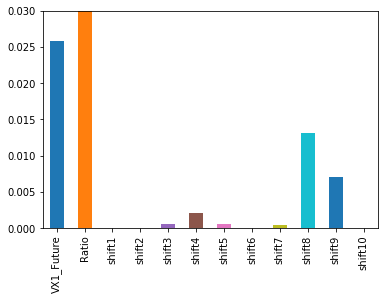

In [233]:
mydata.corr().iloc[:,1].plot(kind='bar').set_ylim(0, 0.03)

### Examine Autocorrelation Function (ACF) of $u_t$, where $u_t = ln(\frac{V_t}{V_{t-1}}) - \widehat{ln(\frac{V_t}{V_{t-1}})}$ 

#### ACF with 10 lags $(l = 10)$

<Container object of 3 artists>

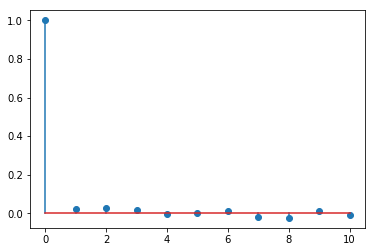

In [234]:
resid = y_test - lr.predict(x_test)
plt.stem(acf(resid,nlags=10))

In [235]:
resid.shape

(5060,)

In [236]:
print(resid[0])

-0.00598782667603


#### ACF with 100 lags $(l = 100)$

(0, 0.03)

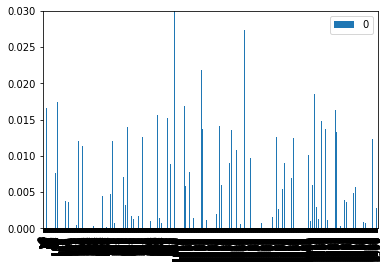

In [237]:
resid = y_test - lr.predict(x_test)
#plt.stem(acf(resid,nlags=100)).set_ylim(0, 0.03)
resid_acf = acf(resid,nlags=2500)
resid_acf = pd.DataFrame(resid_acf)
resid_acf.plot(kind='bar').set_ylim(0, 0.03)

#### Run loop to calculate R^2, residual, ACF & BIC for different values of l

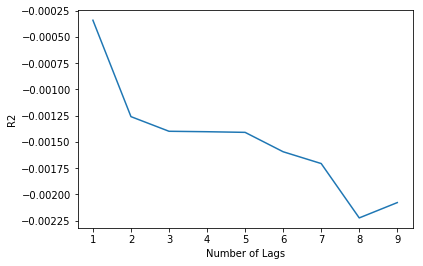

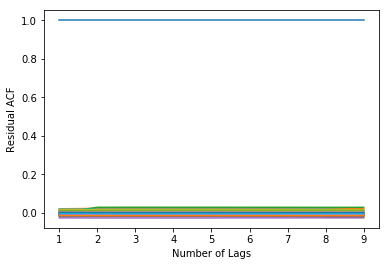

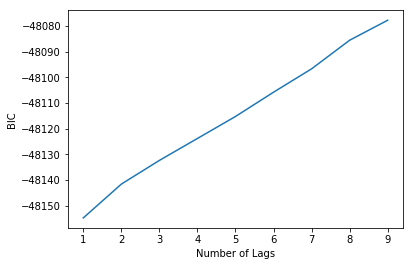

In [238]:
L = range(1,10)
r2 = []
resid_acf = []
bic = []
nTrain = int(.75*x.shape[0])
for l in L:
    y = mydata.iloc[:,1].values
    x = mydata.iloc[:,2:2+l].values
    x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]
    lr = linear_model.LinearRegression()
    lr.fit(x_train,y_train)
    r2.append(lr.score(x_test, y_test))
    resid = y_test - lr.predict(x_test)
    resid_acf.append(acf(resid))
    rss = sum(resid**2)
    n = len(resid)
    k = l
    bic.append(n*np.log(rss/n) + k*np.log(n))

plt.plot(L,r2)
plt.xlabel('Number of Lags')
plt.ylabel('R2')
plt.show()

plt.plot(L,resid_acf)
plt.xlabel('Number of Lags')
plt.ylabel('Residual ACF')
plt.show()

plt.plot(L,bic)
plt.xlabel('Number of Lags')
plt.ylabel('BIC')
plt.show()

In [239]:
len(resid_acf)

9

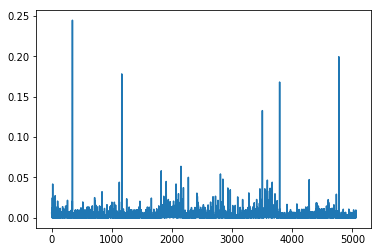

In [240]:
resid = y_test - lr.predict(x_test)
plt.plot(np.abs(resid))

#### Apply Ljung-Box Test for Serial Correlation in VX1 Returns

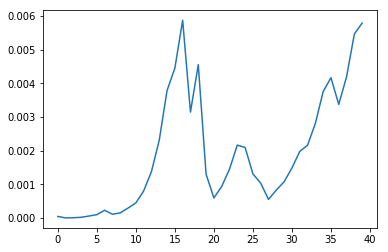

In [241]:
plt.plot(acorr_ljungbox(mydata['Ratio'])[1])

<Container object of 3 artists>

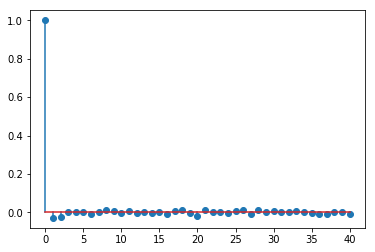

In [242]:
plt.stem(acf(mydata['Ratio'],nlags=40))

#### Check for autocorrelation in the model residuals

In [243]:
acorr_ljungbox(resid)

(array([  2.97735933,   7.39145163,   8.65442426,   8.69527633,
          8.80544336,   9.61356197,  11.20535881,  13.93172433,
         15.10376014,  15.37553751,  15.66709812,  16.70647794,
         16.8903927 ,  17.39178541,  18.68112188,  19.25644674,
         19.26529118,  19.55389096,  19.59263623,  19.64672301,
         19.70704867,  19.7897099 ,  19.78992007,  19.79067585,
         20.48198639,  20.64336306,  20.65953505,  22.04988122,
         22.43660797,  23.40470988,  24.40779891,  24.40852547,
         24.54590882,  27.61459684,  27.61723394,  27.83222723,
         27.83290633,  27.89755992,  27.94949786,  27.97608254]),
 array([ 0.08443693,  0.02482943,  0.03425648,  0.06918417,  0.11708057,
         0.14189761,  0.12990883,  0.08356245,  0.08812501,  0.11895844,
         0.15394659,  0.16097618,  0.20436327,  0.23590008,  0.22854922,
         0.25558923,  0.31351894,  0.35848663,  0.4194545 ,  0.48021473,
         0.53987897,  0.59619201,  0.65454925,  0.70861557,  0.721

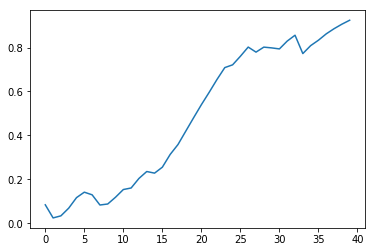

In [244]:
plt.plot(acorr_ljungbox(resid)[1])

### Build Secondary Null:
### Predict log of VX1 price as function of log for 'OPT' synthetic price: $\widehat{ln(\frac{V_{t}}{V_{t-1}})} = \alpha + \beta ln(\frac{OPT_{t-1}}{OPT_{t-2}})$ 

In [245]:
mydata = master[['VX1_Future','OPT']].copy()
mydata['ratio'] = np.log(mydata['VX1_Future']/mydata['VX1_Future'].shift(1))
mydata['ratio_opt'] = np.log(mydata['OPT']/mydata['OPT'].shift(1))

In [246]:
mydata['OPT_shift1'] = mydata['ratio_opt'].shift(1)
mydata['OPT_shift2'] = mydata['ratio_opt'].shift(2)
mydata['OPT_shift3'] = mydata['ratio_opt'].shift(3)
mydata['OPT_shift4'] = mydata['ratio_opt'].shift(4)
mydata['OPT_shift5'] = mydata['ratio_opt'].shift(5)
mydata['OPT_shift6'] = mydata['ratio_opt'].shift(6)
mydata['OPT_shift7'] = mydata['ratio_opt'].shift(7)
mydata['OPT_shift8'] = mydata['ratio_opt'].shift(8)
mydata['OPT_shift9'] = mydata['ratio_opt'].shift(9)
mydata['OPT_shift10'] = mydata['ratio_opt'].shift(10)
mydata.dropna(inplace=True)
mydata.head()

,VX1_Future,OPT,ratio,ratio_opt,OPT_shift1,OPT_shift2,OPT_shift3,OPT_shift4,OPT_shift5,OPT_shift6,OPT_shift7,OPT_shift8,OPT_shift9,OPT_shift10
2015-01-02 11:30:00,18.575,15.5831,-0.008043,0.003465,-0.003542,0.025482,0.000764,0.015488,0.036192,-0.021412,0.006143,0.037482,0.019177,-0.007878
2015-01-02 11:40:00,18.675,15.7529,0.005369,0.010837,0.003465,-0.003542,0.025482,0.000764,0.015488,0.036192,-0.021412,0.006143,0.037482,0.019177
2015-01-02 11:50:00,18.625,15.8899,-0.002681,0.008659,0.010837,0.003465,-0.003542,0.025482,0.000764,0.015488,0.036192,-0.021412,0.006143,0.037482
2015-01-02 12:00:00,18.475,15.7133,-0.008086,-0.011176,0.008659,0.010837,0.003465,-0.003542,0.025482,0.000764,0.015488,0.036192,-0.021412,0.006143
2015-01-02 12:10:00,18.225,15.1536,-0.013624,-0.036269,-0.011176,0.008659,0.010837,0.003465,-0.003542,0.025482,0.000764,0.015488,0.036192,-0.021412


In [247]:
y = mydata.iloc[:,2].values
x = mydata.iloc[:,4:].values

In [248]:
nTrain = int(.75*x.shape[0])
x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]

In [249]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [250]:
r2_score(y_test,lr.predict(x_test))

-0.0010259361697957381

#### Show weighting/impact of individual regressors

In [251]:
lr.coef_

array([ 0.00162631, -0.0084347 , -0.00362085, -0.00363755, -0.0001892 ,
        0.00133496, -0.00109461,  0.01144877,  0.00137689, -0.00099117])

#### Show correlation of the inidividual regressors

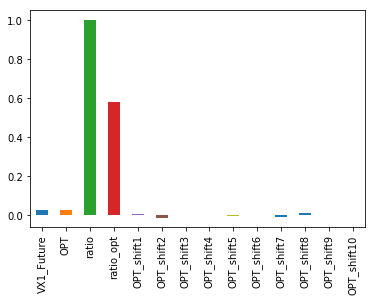

In [252]:
#mydata.corr().iloc[:,2].plot(kind='bar').set_ylim(0, 0.03)
mydata.corr().iloc[:,2].plot(kind='bar')

### Examine Autocorrelation Function (ACF) of $u_t$ for Secondary Null Model (OPT), where $u_t = ln(\frac{V_t}{V_{t-1}}) - \widehat{ln(\frac{V_t}{V_{t-1}})}$ 

#### ACF with 10 lags $(l = 10)$

<Container object of 3 artists>

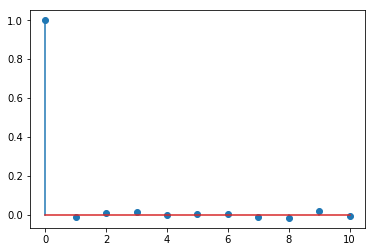

In [253]:
OPTresid = y_test - lr.predict(x_test)
plt.stem(acf(OPTresid,nlags=10))

#### ACF with 100 lags $(l = 100)$

<Container object of 3 artists>

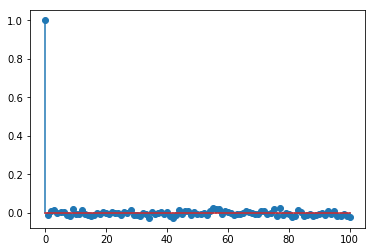

In [254]:
OPTresid = y_test - lr.predict(x_test)
plt.stem(acf(OPTresid,nlags=100))

In [255]:
n*np.log(rss/n)

-48154.463388197975

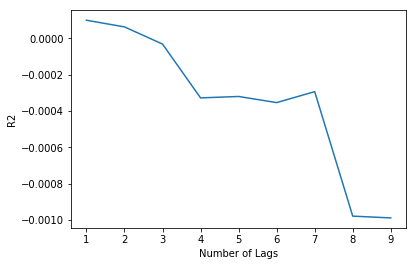

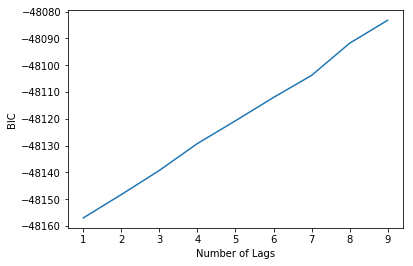

In [256]:
L = range(1,10)
r2 = []
bic = []
nTrain = int(.75*x.shape[0])
for l in L:
    y = mydata.iloc[:,2].values
    x = mydata.iloc[:,4:4+l].values
    x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]
    lr = linear_model.LinearRegression()
    lr.fit(x_train,y_train)
    r2.append(lr.score(x_test, y_test))
    resid = y_test - lr.predict(x_test)
    rss = sum(resid**2)
    n = len(resid)
    k = l
    bic.append(n*np.log(rss/n) + k*np.log(n))

plt.plot(L,r2)
plt.xlabel('Number of Lags')
plt.ylabel('R2')
plt.show()

plt.plot(L,bic)
plt.xlabel('Number of Lags')
plt.ylabel('BIC')
plt.show()

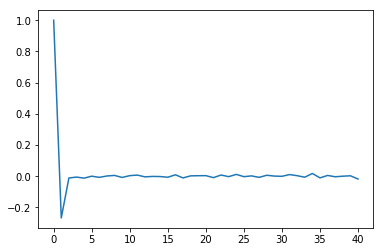

In [257]:
plt.plot(acf(mydata['ratio_opt']))

#### Apply Ljung-Box Test for Serial Correlation in OPT Returns

In [258]:
#plt.plot(acorr_ljungbox(mydata['ratio_opt'])[1])

#### Apply Ljung-Box Test to check for Autocorrelation in residuals of OPT model

In [259]:
acorr_ljungbox(OPTresid)

(array([  0.86035085,   1.15691364,   2.30620005,   2.31210933,
          2.39621806,   2.45816361,   3.22968184,   4.51563927,
          6.30289362,   6.56813398,   6.90426776,   8.02202454,
          8.15996034,   8.59171162,   9.8481307 ,  10.32711529,
         10.32790097,  10.61396298,  10.67511619,  10.71836679,
         10.77376425,  10.8499126 ,  10.85006574,  10.85229304,
         11.57582853,  11.75476334,  11.78104184,  13.30955389,
         13.68353317,  14.57399894,  15.60202155,  15.61214293,
         15.67944397,  19.00675784,  19.04512043,  19.19830039,
         19.19983639,  19.24561408,  19.30699722,  19.38142553]),
 array([ 0.35364053,  0.56076306,  0.51133418,  0.67856523,  0.79203719,
         0.87312013,  0.86297309,  0.80786642,  0.70926226,  0.76548925,
         0.80678224,  0.78340688,  0.83302516,  0.85628327,  0.82918257,
         0.84899639,  0.88929969,  0.91001476,  0.93428367,  0.95320163,
         0.96701342,  0.97682443,  0.98466636,  0.99002695,  0.989

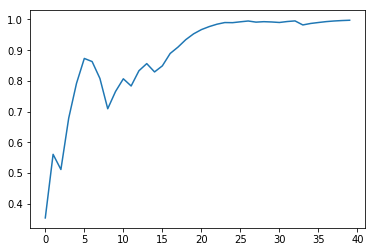

In [260]:
plt.plot(acorr_ljungbox(OPTresid)[1])

In [207]:
mydata = master['VX1-OPT_Spread'].to_frame()
#mydata['ratio_VX1-OPT'] = np.log(mydata['VX1-OPT_Spread']/mydata['VX1-OPT_Spread'].shift(1))
mydata['ratio_VX1-OPT'] = (mydata['VX1-OPT_Spread']/mydata['VX1-OPT_Spread'].shift(1))

In [208]:
mydata.isna().sum()

VX1-OPT_Spread    0
ratio_VX1-OPT     1
dtype: int64

In [209]:
mydata = mydata[~mydata['ratio_VX1-OPT'].isna()]

In [210]:
mydata.head(10)

,VX1-OPT_Spread,ratio_VX1-OPT
2015-01-02 09:50:00,3.4435,1.064748
2015-01-02 10:00:00,3.2757,0.951271
2015-01-02 10:10:00,3.0872,0.942455
2015-01-02 10:20:00,2.9970,0.970783
2015-01-02 10:30:00,3.3090,1.104104
2015-01-02 10:40:00,3.5527,1.073648
2015-01-02 10:50:00,3.2944,0.927295
2015-01-02 11:00:00,3.2328,0.981302
2015-01-02 11:10:00,3.0407,0.940578
2015-01-02 11:20:00,3.1958,1.051008


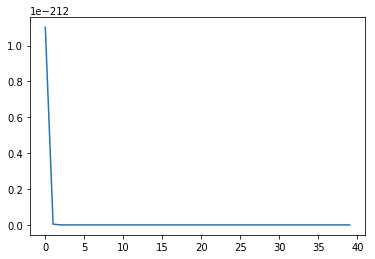

In [211]:
plt.plot(acorr_ljungbox(mydata['ratio_VX1-OPT'])[1])

In [212]:
acorr_ljungbox(mydata['ratio_VX1-OPT'])

(array([  968.77233002,   987.36156886,  1128.38480813,  1137.27845351,
         1139.06301787,  1142.90899054,  1145.21606042,  1203.54299351,
         1234.58083992,  1234.88677987,  1288.22381948,  1300.41776456,
         1376.9699933 ,  1396.93443094,  1481.29942625,  1492.26414844,
         1531.88611358,  1534.09305383,  1535.00399524,  1536.46331237,
         1537.38677283,  1576.06531578,  1578.05551935,  1605.35593356,
         1607.40204262,  1622.51844565,  1724.82448447,  1726.9103448 ,
         1737.34996673,  1746.53860789,  1747.66849922,  1748.4143192 ,
         1748.50090139,  1769.6025733 ,  1799.37817089,  1808.46262312,
         1816.38152701,  1828.64845496,  1877.94623223,  1902.11577358]),
 array([  1.10190329e-212,   3.95511851e-215,   2.52874613e-244,
          6.29102651e-245,   4.63865583e-244,   1.08372556e-243,
          4.94830558e-243,   1.64539455e-254,   4.14678401e-260,
          4.29277630e-259,   1.54974810e-269,   4.04856341e-271,
          1.404246

### Build Third Null:
### Predict log of VX1 price as function of log for implied vol of VIX options: $\widehat{ln(\frac{V_{t}}{V_{t-1}})} = \alpha + \beta ln(\frac{V\sigma_{t-1}}{V\sigma_{t-2}})$ 

#### Load VIX options prices (implied volatility levels for options on VX1, the lead VIX future) 

In [48]:
#vix_vol = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vix_vol.pkl', "rb"))
#vix_vol = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\vix_vol_2terms.pkl', "rb"))

In [49]:
#mydata = vx1_opt['Mid'].to_frame()

In [261]:
mydata = master[['VX1_Future','VIX_ImpVol']].copy()
mydata['ratio'] = np.log(mydata['VX1_Future']/mydata['VX1_Future'].shift(1))
mydata['ratio_VIX_ImpVol'] = np.log(mydata['VIX_ImpVol']/mydata['VIX_ImpVol'].shift(1))

In [262]:
mydata['shift1'] = mydata['ratio_VIX_ImpVol'].shift(1)
mydata['shift2'] = mydata['ratio_VIX_ImpVol'].shift(2)
mydata['shift3'] = mydata['ratio_VIX_ImpVol'].shift(3)
mydata['shift4'] = mydata['ratio_VIX_ImpVol'].shift(4)
mydata['shift5'] = mydata['ratio_VIX_ImpVol'].shift(5)
mydata['shift6'] = mydata['ratio_VIX_ImpVol'].shift(6)
mydata['shift7'] = mydata['ratio_VIX_ImpVol'].shift(7)
mydata['shift8'] = mydata['ratio_VIX_ImpVol'].shift(8)
mydata['shift9'] = mydata['ratio_VIX_ImpVol'].shift(9)
mydata['shift10'] = mydata['ratio_VIX_ImpVol'].shift(10)
mydata.dropna(inplace=True)
mydata.head()

,VX1_Future,VIX_ImpVol,ratio,ratio_VIX_ImpVol,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10
2015-01-02 11:30:00,18.575,1.3041,-0.008043,0.005999,0.009612,0.033582,-0.001368,0.005404,0.039929,0.003795,-0.000084,0.035164,0.002015,-0.003501
2015-01-02 11:40:00,18.675,1.2942,0.005369,-0.007620,0.005999,0.009612,0.033582,-0.001368,0.005404,0.039929,0.003795,-0.000084,0.035164,0.002015
2015-01-02 11:50:00,18.625,1.2983,-0.002681,0.003163,-0.007620,0.005999,0.009612,0.033582,-0.001368,0.005404,0.039929,0.003795,-0.000084,0.035164
2015-01-02 12:00:00,18.475,1.2559,-0.008086,-0.033203,0.003163,-0.007620,0.005999,0.009612,0.033582,-0.001368,0.005404,0.039929,0.003795,-0.000084
2015-01-02 12:10:00,18.225,1.2449,-0.013624,-0.008797,-0.033203,0.003163,-0.007620,0.005999,0.009612,0.033582,-0.001368,0.005404,0.039929,0.003795


In [263]:
y = mydata.iloc[:,2].values
x = mydata.iloc[:,4:].values

In [264]:
nTrain = int(.75*x.shape[0])
x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]

In [265]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [266]:
r2_score(y_test,lr.predict(x_test))

-0.00062052483579555506

In [267]:
lr.coef_

array([-0.00103965, -0.00053696,  0.00062105,  0.00068353, -0.000441  ,
       -0.00137277,  0.00192393,  0.00497347,  0.00226999,  0.00455936])

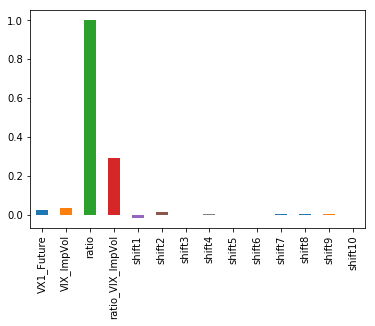

In [268]:
mydata.corr().iloc[:,2].plot(kind='bar')

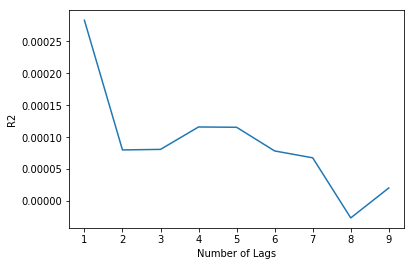

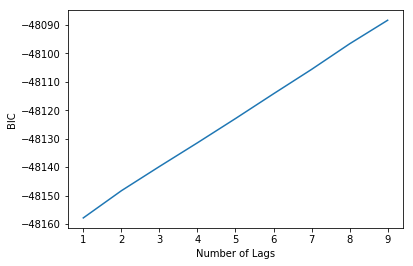

In [269]:
L = range(1,10)
r2 = []
bic = []
nTrain = int(.75*x.shape[0])
for l in L:
    y = mydata.iloc[:,2].values
    x = mydata.iloc[:,4:4+l].values
    x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]
    lr = linear_model.LinearRegression()
    lr.fit(x_train,y_train)
    r2.append(lr.score(x_test, y_test))
    resid = y_test - lr.predict(x_test)
    rss = sum(resid**2)
    n = len(resid)
    k = l
    bic.append(n*np.log(rss/n) + k*np.log(n))

plt.plot(L,r2)
plt.xlabel('Number of Lags')
plt.ylabel('R2')
plt.show()

plt.plot(L,bic)
plt.xlabel('Number of Lags')
plt.ylabel('BIC')
plt.show()

In [270]:
predictdata = mydata.iloc[nTrain:,:].copy()

In [271]:
predictdata['resid'] = np.abs(y_test - (lr.predict(x_test)))

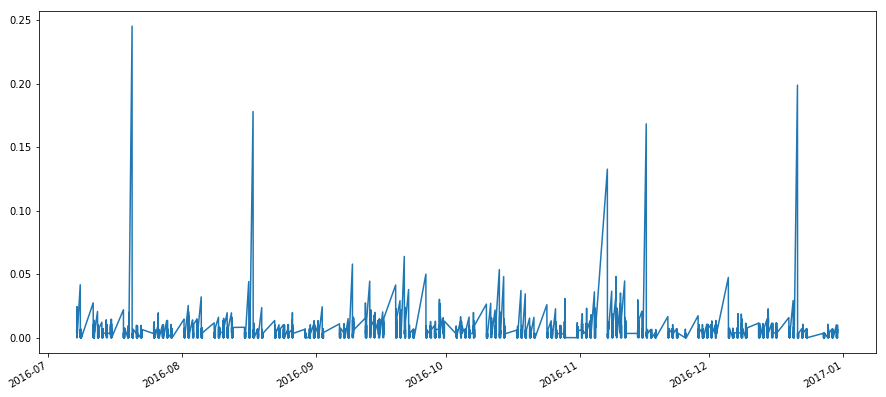

In [272]:
predictdata['resid'].plot(figsize=(15,7))

In [273]:
predictdata[predictdata['resid']>0.05]

,VX1_Future,VIX_ImpVol,ratio,ratio_VIX_ImpVol,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,resid
2016-07-20 09:40:00,15.625,0.8781,0.245389,-0.018057,-0.006244,0.011739,-0.079420,0.008345,0.001572,0.002521,0.001263,-0.001999,0.058984,-0.077518,0.245422
2016-08-17 09:40:00,15.325,0.8972,0.178089,-0.003116,0.015904,-0.011114,-0.005789,0.000222,-0.000444,0.003223,-0.002113,-0.003881,-0.010787,-0.000109,0.178140
2016-09-09 09:40:00,14.175,0.8904,0.058093,0.076409,-0.003751,0.017053,-0.010996,0.006828,-0.000856,-0.004391,0.046456,0.011669,-0.004761,-0.055310,0.057980
2016-09-21 09:40:00,16.925,1.0497,0.064046,-0.017471,-0.000655,-0.003456,0.005516,0.003287,0.001318,-0.003760,-0.007385,0.011805,0.000471,-0.008450,0.064002
2016-09-26 09:40:00,16.375,1.0061,0.050089,0.112999,-0.001223,0.000334,-0.006759,0.015806,-0.007823,-0.001001,0.008264,-0.000336,0.000000,-0.007816,0.050074
2016-10-13 09:40:00,17.225,1.0852,0.053664,0.063532,-0.075531,0.097972,0.008066,-0.003032,-0.000807,-0.002619,-0.001608,0.001407,0.001308,-0.006824,0.053638
2016-11-07 09:40:00,16.925,1.3061,-0.132608,-0.083963,0.025742,-0.037360,0.011337,0.011324,0.000641,0.011894,-0.026600,0.042071,0.009118,-0.001255,0.132731
2016-11-16 09:40:00,15.625,0.8701,0.168655,-0.011768,-0.354913,0.347895,0.007699,0.005128,-0.011021,-0.002032,0.006675,0.006949,-0.001599,0.002056,0.168432
2016-12-21 09:40:00,14.125,0.8347,0.199099,-0.007400,0.004888,-0.064441,0.008665,0.067557,-0.011302,-0.062114,0.006651,0.004535,-0.002043,0.002498,0.198904


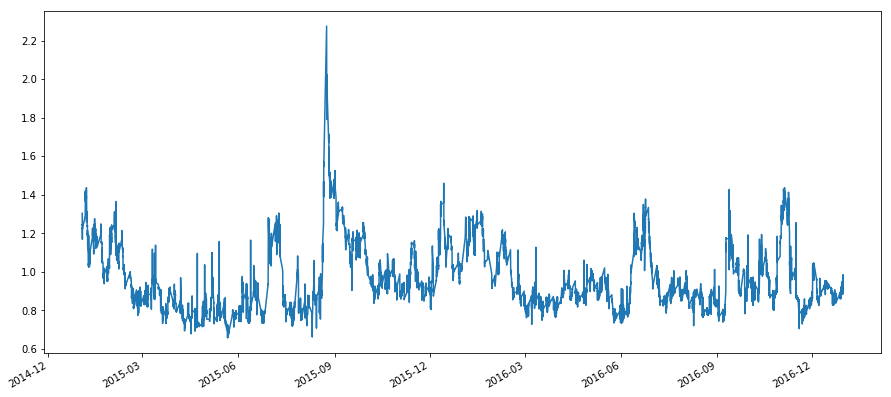

In [274]:
mydata['VIX_ImpVol'].plot(figsize=(15,7))

### Examine Autocorrelation Function (ACF) of $u_t$ for Secondary Null Model (VIX_ImpVol), where $u_t = ln(\frac{V_t}{V_{t-1}}) - \widehat{ln(\frac{V_t}{V_{t-1}})}$ 

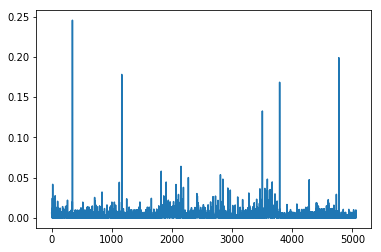

In [275]:
VIXvol_resid = y_test - lr.predict(x_test)
plt.plot(np.abs(VIXvol_resid))
#plt.stem(acf(resid,nlags=100))

<Container object of 3 artists>

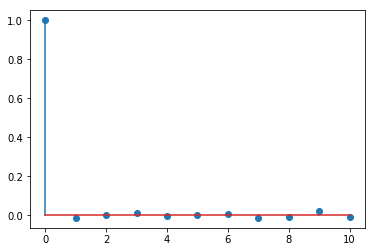

In [276]:
plt.stem(acf(VIXvol_resid,nlags=10))

#### Apply Ljung-Box Test to check for Autocorrelation in residuals of VIX_ImpVol model

In [277]:
acorr_ljungbox(VIXvol_resid)

(array([  0.68192407,   0.68192431,   1.29253618,   1.31454339,
          1.39791954,   1.5071625 ,   2.42007279,   2.6743404 ,
          4.703607  ,   5.06453301,   5.43558526,   6.68045448,
          6.82238979,   7.29361742,   8.52576694,   9.00384195,
          9.00400377,   9.25831939,   9.31576375,   9.35742581,
          9.4233377 ,   9.49500672,   9.49502818,   9.49911414,
         10.23928427,  10.36392154,  10.38564918,  11.9474688 ,
         12.30689905,  13.24569105,  14.15249311,  14.17387931,
         14.29129117,  17.52634411,  17.55124981,  17.68291565,
         17.68341305,  17.74908299,  17.78750123,  17.85425452]),
 array([ 0.40892496,  0.71108582,  0.73090619,  0.85890324,  0.92454072,
         0.95901736,  0.93299446,  0.95310518,  0.85934258,  0.88682564,
         0.90825284,  0.87798814,  0.91107091,  0.92279951,  0.90098119,
         0.91325523,  0.94013611,  0.95345492,  0.96785907,  0.97838544,
         0.98547283,  0.99033443,  0.99399097,  0.99632204,  0.995

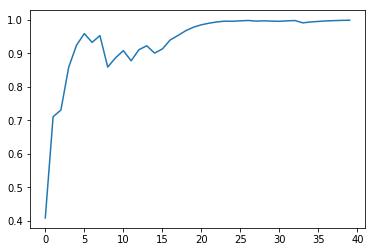

In [278]:
plt.plot(acorr_ljungbox(VIXvol_resid)[1])

### Build Fourth Null:
### Predict log of VX1 price as function of log for SPX Index Prices: $\widehat{ln(\frac{V_t}{V_{t-1}})} = \alpha + \beta ln(\frac{SPX_{t-1}}{SPX_{t-2}})$ 

In [279]:
#spx_intra_returns = pickle.load(open(os.getcwd() + r'\Data\Intraday\Pickle\spx_intra_returns.pkl', "rb"))

In [280]:
#mydata = vx1_opt['Mid'].to_frame()

In [281]:
mydata = master[['VX1_Future','SPX_Index(fwd)']].copy()
mydata['ratio'] = np.log(mydata['VX1_Future']/mydata['VX1_Future'].shift(1))
mydata['ratio_SPX'] = np.log(mydata['SPX_Index(fwd)']/mydata['SPX_Index(fwd)'].shift(1))

In [282]:
mydata['shift1'] = mydata['ratio_SPX'].shift(1)
mydata['shift2'] = mydata['ratio_SPX'].shift(2)
mydata['shift3'] = mydata['ratio_SPX'].shift(3)
mydata['shift4'] = mydata['ratio_SPX'].shift(4)
mydata['shift5'] = mydata['ratio_SPX'].shift(5)
mydata['shift6'] = mydata['ratio_SPX'].shift(6)
mydata['shift7'] = mydata['ratio_SPX'].shift(7)
mydata['shift8'] = mydata['ratio_SPX'].shift(8)
mydata['shift9'] = mydata['ratio_SPX'].shift(9)
mydata['shift10'] = mydata['ratio_SPX'].shift(10)
mydata.dropna(inplace=True)
mydata.head()

,VX1_Future,SPX_Index(fwd),ratio,ratio_SPX,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10
2015-01-02 11:30:00,18.575,2052.26,-0.008043,0.001190,-0.001087,-0.001908,0.000574,-0.000584,-0.003569,0.000465,-0.000155,-0.002513,-0.000184,-0.001522
2015-01-02 11:40:00,18.675,2052.14,0.005369,-0.000058,0.001190,-0.001087,-0.001908,0.000574,-0.000584,-0.003569,0.000465,-0.000155,-0.002513,-0.000184
2015-01-02 11:50:00,18.625,2051.52,-0.002681,-0.000302,-0.000058,0.001190,-0.001087,-0.001908,0.000574,-0.000584,-0.003569,0.000465,-0.000155,-0.002513
2015-01-02 12:00:00,18.475,2052.82,-0.008086,0.000633,-0.000302,-0.000058,0.001190,-0.001087,-0.001908,0.000574,-0.000584,-0.003569,0.000465,-0.000155
2015-01-02 12:10:00,18.225,2055.96,-0.013624,0.001528,0.000633,-0.000302,-0.000058,0.001190,-0.001087,-0.001908,0.000574,-0.000584,-0.003569,0.000465


In [283]:
y = mydata.iloc[:,2].values
x = mydata.iloc[:,4:].values

In [284]:
nTrain = int(.75*x.shape[0])
x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]

In [285]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [286]:
r2_score(y_test,lr.predict(x_test))

-0.00072394957634314139

In [287]:
lr.coef_

array([ 0.0074768 ,  0.03661362,  0.04624795,  0.03246802, -0.07108682,
        0.01959787, -0.01810486, -0.10913556, -0.00267489, -0.03115635])

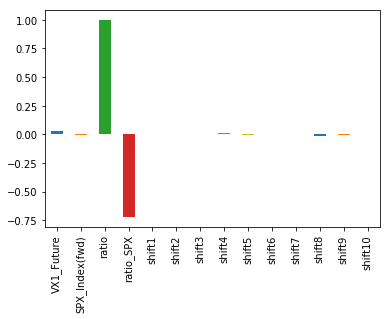

In [288]:
mydata.corr().iloc[:,2].plot(kind='bar')

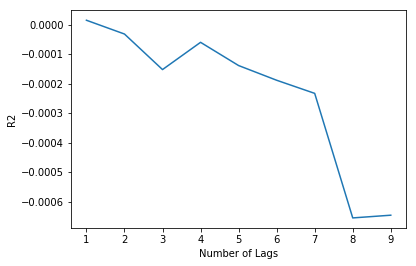

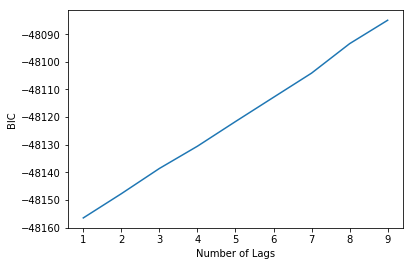

In [289]:
L = range(1,10)
r2 = []
bic = []
nTrain = int(.75*x.shape[0])
for l in L:
    y = mydata.iloc[:,2].values
    x = mydata.iloc[:,4:4+l].values
    x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]
    lr = linear_model.LinearRegression()
    lr.fit(x_train,y_train)
    r2.append(lr.score(x_test, y_test))
    resid = y_test - lr.predict(x_test)
    rss = sum(resid**2)
    n = len(resid)
    k = l
    bic.append(n*np.log(rss/n) + k*np.log(n))

plt.plot(L,r2)
plt.xlabel('Number of Lags')
plt.ylabel('R2')
plt.show()

plt.plot(L,bic)
plt.xlabel('Number of Lags')
plt.ylabel('BIC')
plt.show()

### Examine Autocorrelation Function (ACF) of $u_t$ for Secondary Null Model (SPX), where $u_t = ln(\frac{V_t}{V_{t-1}}) - \widehat{ln(\frac{V_t}{V_{t-1}})}$ 

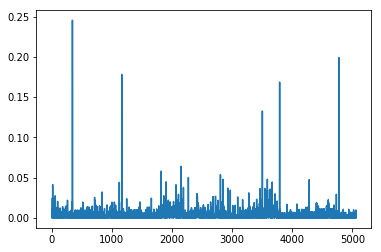

In [290]:
SPXresid = y_test - lr.predict(x_test)
plt.plot(np.abs(SPXresid))

<Container object of 3 artists>

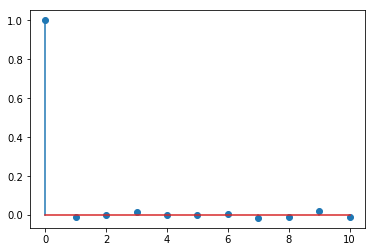

In [291]:
plt.stem(acf(SPXresid,nlags=10))

#### Apply Ljung-Box Test to check for Autocorrelation in residuals of SPX model

In [292]:
acorr_ljungbox(SPXresid)

(array([  0.65606386,   0.66797993,   1.69752524,   1.69856914,
          1.69905013,   1.85143702,   2.87181977,   3.55904084,
          5.62541062,   5.95823066,   6.30411476,   7.46212988,
          7.62339189,   8.07335075,   9.25890822,   9.74675038,
          9.74676829,  10.01177997,  10.06341452,  10.10714866,
         10.17740685,  10.24411407,  10.24429147,  10.24667359,
         10.94972333,  11.11620574,  11.13282137,  12.66488996,
         13.02701804,  13.93256046,  14.95774552,  14.97195071,
         15.02278926,  18.29787077,  18.32617973,  18.40799738,
         18.40866442,  18.45942612,  18.52273152,  18.58635892]),
 array([ 0.417953  ,  0.71606097,  0.63748413,  0.79097753,  0.8890194 ,
         0.93284214,  0.89660128,  0.8945595 ,  0.77674398,  0.81876022,
         0.85232182,  0.82562603,  0.86724106,  0.88546968,  0.86359539,
         0.87951465,  0.91389223,  0.9315212 ,  0.95136411,  0.96618715,
         0.97651535,  0.98395314,  0.9896619 ,  0.99345251,  0.993

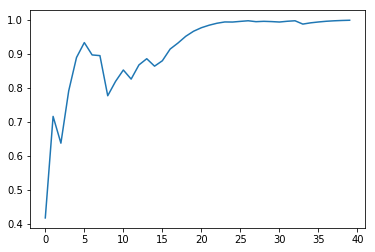

In [293]:
plt.plot(acorr_ljungbox(SPXresid)[1])

### Build Fifth Null:
### Predict log of VX1 price as function of VX1-OPT Spread Prices: $\widehat{ln(\frac{V_t}{V_{t-1}})} = \alpha + \beta (\frac{VX1-OPT_{t-1}}{VX1-OPT_{t-2}})$ 

In [294]:
mydata = master[['VX1_Future','VX1-OPT_Spread']].copy()
mydata['ratio'] = np.log(mydata['VX1_Future']/mydata['VX1_Future'].shift(1))
mydata['ratio_VX1-OPT'] = mydata['VX1-OPT_Spread']/mydata['VX1-OPT_Spread'].shift(1)

In [295]:
mydata['shift1'] = mydata['ratio_VX1-OPT'].shift(1)
mydata['shift2'] = mydata['ratio_VX1-OPT'].shift(2)
mydata['shift3'] = mydata['ratio_VX1-OPT'].shift(3)
mydata['shift4'] = mydata['ratio_VX1-OPT'].shift(4)
mydata['shift5'] = mydata['ratio_VX1-OPT'].shift(5)
mydata['shift6'] = mydata['ratio_VX1-OPT'].shift(6)
mydata['shift7'] = mydata['ratio_VX1-OPT'].shift(7)
mydata['shift8'] = mydata['ratio_VX1-OPT'].shift(8)
mydata['shift9'] = mydata['ratio_VX1-OPT'].shift(9)
mydata['shift10'] = mydata['ratio_VX1-OPT'].shift(10)
mydata.dropna(inplace=True)
mydata.head()

,VX1_Future,VX1-OPT_Spread,ratio,ratio_VX1-OPT,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10
2015-01-02 11:30:00,18.575,2.9919,-0.008043,0.936198,1.051008,0.940578,0.981302,0.927295,1.073648,1.104104,0.970783,0.942455,0.951271,1.064748
2015-01-02 11:40:00,18.675,2.9221,0.005369,0.976670,0.936198,1.051008,0.940578,0.981302,0.927295,1.073648,1.104104,0.970783,0.942455,0.951271
2015-01-02 11:50:00,18.625,2.7351,-0.002681,0.936005,0.976670,0.936198,1.051008,0.940578,0.981302,0.927295,1.073648,1.104104,0.970783,0.942455
2015-01-02 12:00:00,18.475,2.7617,-0.008086,1.009725,0.936005,0.976670,0.936198,1.051008,0.940578,0.981302,0.927295,1.073648,1.104104,0.970783
2015-01-02 12:10:00,18.225,3.0714,-0.013624,1.112141,1.009725,0.936005,0.976670,0.936198,1.051008,0.940578,0.981302,0.927295,1.073648,1.104104


In [296]:
y = mydata.iloc[:,2].values
x = mydata.iloc[:,4:].values

In [297]:
nTrain = int(.75*x.shape[0])
x_train, x_test, y_train, y_test = x[:nTrain,], x[nTrain:,], y[:nTrain,], y[nTrain:,]

In [298]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [299]:
r2_score(y_test,lr.predict(x_test))

-0.0011313217218542615

In [300]:
lr.coef_

array([-0.00010754,  0.0010666 ,  0.00082007, -0.00017598,  0.00059012,
       -0.00088364, -0.00054035,  0.00022437,  0.00205699,  0.00339172])

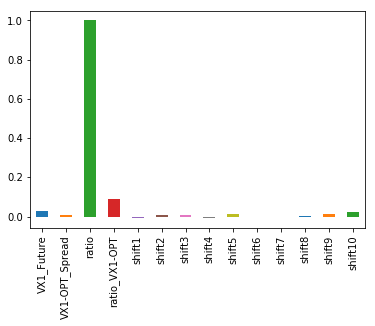

In [301]:
mydata.corr().iloc[:,2].plot(kind='bar')

### Examine Autocorrelation Function (ACF) of $u_t$ for 5th Null Model (VX1-OPT), where $u_t = ln(\frac{V_t}{V_{t-1}}) - \widehat{ln(\frac{V_t}{V_{t-1}})}$ 

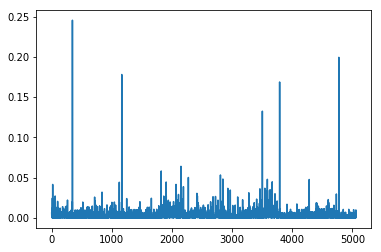

In [302]:
spread_resid = y_test - lr.predict(x_test)
plt.plot(np.abs(spread_resid))

<Container object of 3 artists>

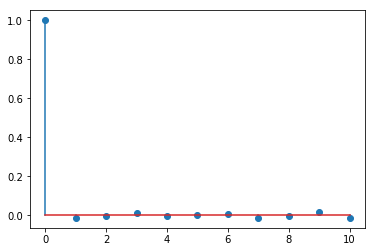

In [303]:
plt.stem(acf(spread_resid,nlags=10))

#### Apply Ljung-Box Test to check for Autocorrelation in residuals of VX1-OPT model

In [304]:
acorr_ljungbox(spread_resid)

(array([  0.66642089,   0.69128545,   1.19437939,   1.21519186,
          1.27449579,   1.46658544,   2.32868786,   2.43660447,
          4.18745235,   4.94472789,   5.2282096 ,   6.40108109,
          6.50996159,   6.91890927,   8.27557949,   8.73027294,
          8.73061168,   9.00315298,   9.07359468,   9.10479707,
          9.16376646,   9.22527579,   9.22847209,   9.2284809 ,
          9.96187117,  10.12199918,  10.12835639,  11.59952837,
         11.97463635,  12.835584  ,  13.7624097 ,  13.80568316,
         13.91163244,  17.20333066,  17.22382277,  17.3588826 ,
         17.35901444,  17.41784184,  17.45447131,  17.54769142]),
 array([ 0.41430224,  0.70776531,  0.75435268,  0.8755911 ,  0.93753403,
         0.96168319,  0.93943553,  0.96462162,  0.89864716,  0.89483951,
         0.91961252,  0.89453027,  0.92561158,  0.93779264,  0.91225958,
         0.92410421,  0.94833578,  0.95966961,  0.97223698,  0.98166137,
         0.98786593,  0.99207386,  0.99512632,  0.99706669,  0.996

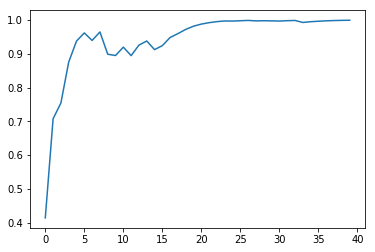

In [305]:
plt.plot(acorr_ljungbox(spread_resid)[1])